In [1]:
%run "/home/kumail/Bioinformatics/pepTrans Code/imports.py"
%run "/home/kumail/Bioinformatics/pepTrans Code/Binding_Site_pepTrans_module.py"
%run "/home/kumail/Bioinformatics/pepTrans Code/Cross_Validation_pepTrans_Binding_Sites.py"
%run "/home/kumail/Bioinformatics/pepTrans Code/pepTrans.py"
%run "/home/kumail/Bioinformatics/pepTrans Code/run_pepTrans_Jupyter.py"
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", message=".*TensorFlow Addons.*")
warnings.filterwarnings("ignore", message=".*you are currently using is 2.9.0 and is not supported.*")
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
tf.config.run_functions_eagerly(True)

/home/kumail/anaconda3/envs/SKS/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/kumail/anaconda3/envs/SKS/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an i

In [ ]:
def pepTrans_binding_site_prediction(test_dataset, weights_path):
    peptide_data, protein_data, labels = read_hdf5_file(test_dataset)

    batch_size = 128
    test_gen = DataGenerator(peptide_data, protein_data, labels, batch_size)

    peptide_length = peptide_data.shape[1]
    protein_length = protein_data.shape[1]
    embedding_dim = peptide_data.shape[2]

    with tf.device('/GPU:1'):  
        model = pepTrans_Binding_Sites(peptide_length, protein_length, embedding_dim)
        model.load_weights(weights_path) 
        print(f"Loaded model weights from {weights_path}")

    mcc_values, auc_values = [], []
    for i in range(len(peptide_data)):
        pred = model.predict([np.expand_dims(peptide_data[i], axis=0),
                              np.expand_dims(protein_data[i], axis=0)], verbose=0).flatten()
        y_true = labels[i].reshape(-1)
        auc, mcc = custom_metrics(tf.convert_to_tensor(y_true, dtype=tf.float32),
                                  tf.convert_to_tensor(pred, dtype=tf.float32))
        mcc_values.append(mcc)
        auc_values.append(auc)

    mean_mcc = np.mean(mcc_values)
    mean_auc = np.mean(auc_values)

    unique_vals = sorted(set(mcc_values))
    counts = [mcc_values.count(val) for val in unique_vals]
    plt.figure(figsize=(10, 6))
    plt.bar(unique_vals, counts, width=0.02, color='skyblue', edgecolor='black')
    plt.title('MCC Distribution - Test Set')
    plt.xlabel('MCC')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', axis='y', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(f"\n=== Test Set Results ===")
    print(f"> Mean MCC: {mean_mcc:.4f}")
    print(f"> Mean AUC: {mean_auc:.4f}")

2025-08-08 15:21:04.611887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-08 15:21:05.482345: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11097 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:0e:00.0, compute capability: 6.1


Loaded model weights from /home/kumail/Bioinformatics/Model/Bindingsites CNN Model/500_0.5589_Generability_Binding_Residue_Pair_Wise_CNN_Model_Weights.h5


2025-08-08 15:21:07.574669: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2025-08-08 15:21:08.431715: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-08-08 15:21:08.448922: E tensorflow/stream_executor/gpu/asm_compiler.cc:105] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.


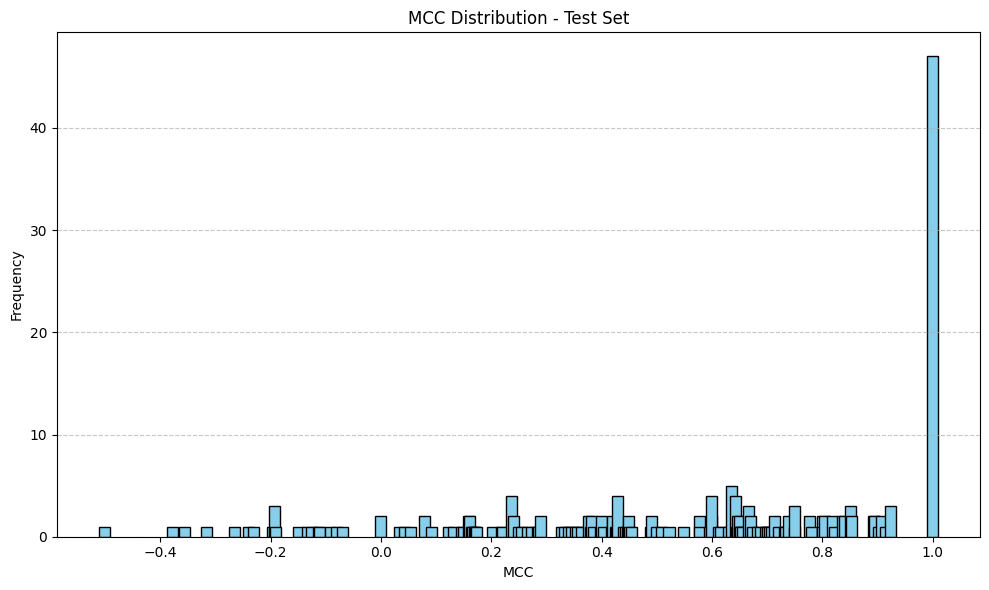


=== Test Set Results ===
> Mean MCC: 0.5589
> Mean AUC: 0.7760


In [ ]:
args = SimpleNamespace(
    mode='bs_G', 
    csv=None,
    vas_csv=None,
    label='Label',
    train_h5=None,
    test_h5="/home/kumail/Bioinformatics/github pepTrans/test dataset/Generalizability/Test_dataset_peptide_binding_sites.h5",
    gpu='1'
)
if args.mode == 'bs_G':
    if not args.test_h5:
        print("Test HDF5 path required for CNN binding site prediction")
        sys.exit()

    model_weights_path = "/home/kumail/Bioinformatics/github pepTrans/pepTrans weight/Generalizability/Generability_Binding_Residue_Pair_Wise_pepTrans_Weights.h5"
    pepTrans_binding_site_prediction(args.test_h5, model_weights_path)

### AlphaFold-3 Predication

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef, roc_auc_score

file_path = "/home/kumail/Bioinformatics/Dataset/AlphaFold3/AlphaFold3_Predications_Test_pepBDB_pep_bindingsites.tsv"
df = pd.read_csv(file_path, sep='\t')

mcc_list = []
auc_list = []

print("Row-wise MCC and AUC scores:")

for index, row in df.iterrows():
    actual = list(map(int, row['actual_pep_binding_vec']))
    predicted = list(map(int, row['alphafold_predications_pep_binding_vec']))

    if len(actual) != len(predicted):
        print(f"Row {index}: Length mismatch, skipping...")
        continue

    y_true_combined = actual[:]
    pred_combined = predicted[:]

    if len(set(actual)) == 1 and len(set(predicted)) == 1:
        y_true_complement = [1 - val for val in actual]  
        y_pred_complement = [1 - p for p in predicted] 
        
        y_true_combined.extend(y_true_complement)
        pred_combined.extend(y_pred_complement)

    elif len(set(actual)) == 1:
        y_true_complement = [1 - val for val in actual]  
        y_pred_complement = [1 - p for p in predicted] 
        
        y_true_combined.extend(y_true_complement)
        pred_combined.extend(y_pred_complement)

    elif len(set(predicted)) == 1:
        y_true_complement = [1 - val for val in actual]  
        y_pred_complement = [1 - p for p in predicted] 
        
        y_true_combined.extend(y_true_complement)
        pred_combined.extend(y_pred_complement)

    mcc = matthews_corrcoef(y_true_combined, pred_combined)
    mcc_list.append(mcc)

    if len(set(y_true_combined)) > 1:
        auc = roc_auc_score(y_true_combined, pred_combined)
        auc_list.append(auc)
    else:
        auc = None  # AUC is not defined for single-class cases

    print(f"Row {index}: MCC = {mcc:.4f}, AUC = {auc:.4f}" if auc is not None else f"Row {index}: MCC = {mcc:.4f}, AUC = N/A")

mean_mcc = np.mean(mcc_list) if mcc_list else None
mean_auc = np.mean(auc_list) if auc_list else None

print("\nFinal Mean Scores:")
print(f"Mean MCC: {mean_mcc:.4f}")
print(f"Mean AUC: {mean_auc:.4f}" if mean_auc is not None else "Mean AUC: N/A")


Row-wise MCC and AUC scores:
Row 0: MCC = 1.0000, AUC = 1.0000
Row 1: MCC = 0.3684, AUC = 0.6842
Row 2: MCC = 1.0000, AUC = 1.0000
Row 3: MCC = 0.5329, AUC = 0.9259
Row 4: MCC = -0.1111, AUC = 0.4444
Row 5: MCC = 0.3800, AUC = 0.6364
Row 6: MCC = 0.8964, AUC = 0.9688
Row 7: MCC = 0.8964, AUC = 0.9688
Row 8: MCC = 0.9139, AUC = 0.9773
Row 9: MCC = 0.1902, AUC = 0.5939
Row 10: MCC = 0.3695, AUC = 0.6813
Row 11: MCC = -0.1111, AUC = 0.4444
Row 12: MCC = 0.1224, AUC = 0.5531
Row 13: MCC = -0.1158, AUC = 0.4317
Row 14: MCC = 0.5930, AUC = 0.7832
Row 15: MCC = 0.1746, AUC = 0.5664
Row 16: MCC = 0.0252, AUC = 0.5113
Row 17: MCC = 0.0462, AUC = 0.5221
Row 18: MCC = 0.2588, AUC = 0.6284
Row 19: MCC = 1.0000, AUC = 1.0000
Row 20: MCC = 1.0000, AUC = 1.0000
Row 21: MCC = 1.0000, AUC = 1.0000
Row 22: MCC = 0.7035, AUC = 0.8535
Row 23: MCC = 0.5960, AUC = 0.7980
Row 24: MCC = 1.0000, AUC = 1.0000
Row 25: MCC = 1.0000, AUC = 1.0000
Row 26: MCC = 0.8788, AUC = 0.9394
Row 27: MCC = 0.4427, AUC = 0.733